# Taxi Demand Forecasting

Taxi Company has collected historical data on taxi orders at airports. To attract more drivers during peak demand periods, the company needs to forecast the number of taxi orders for the next hour. For this purpose, a predictive model is being developed.

Task:
The task is to forecast the number of taxi orders for the next hour. The goal is to build a model that can accurately predict the demand for taxi services based on historical data.

## Data Preparation 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose

# import models
import xgboost as xgb
from prophet import Prophet
from sklearn.linear_model import LinearRegression


color_pal = sns.color_palette()
plt.style.use('ggplot')

In [5]:
df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [8]:
print(df.index.is_monotonic)

True


Let's perform a time-based resampling and aggregation operation

In [11]:
df = df.resample('1H').sum()

In [12]:
last_week = df['2018-08-20':'2018-08-26']

## Analysis

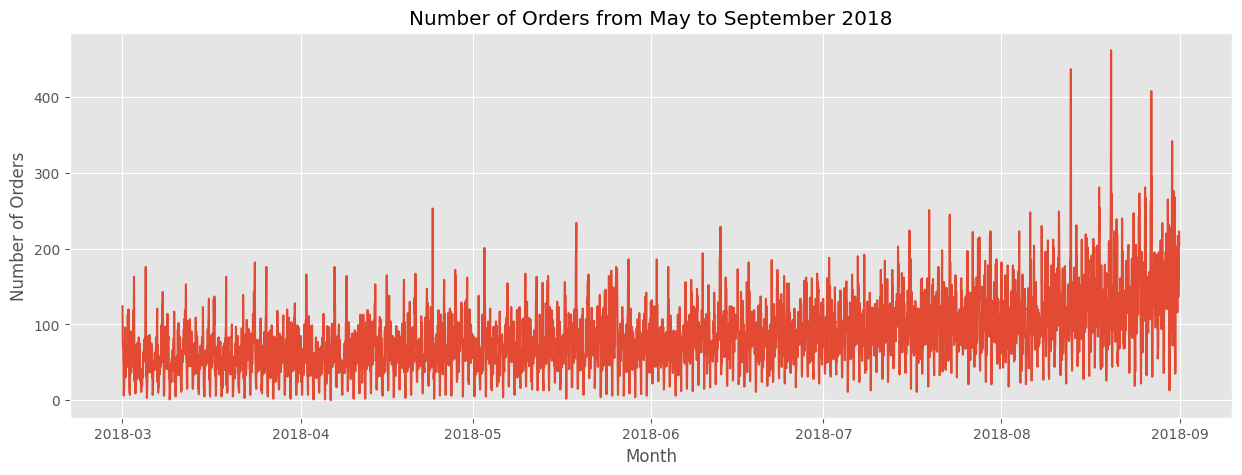

In [13]:
plt.figure(figsize=(15, 5))
plt.plot(df.index, df)
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.title('Number of Orders from May to September 2018')
plt.show()

In [14]:
print(f"Mean: {df['num_orders'].mean()}")
print(f"Median: {df['num_orders'].median()}")
print(f"Standard Deviation: {df['num_orders'].std()}")

Mean: 84.42278079710145
Median: 78.0
Standard Deviation: 45.023853419354026


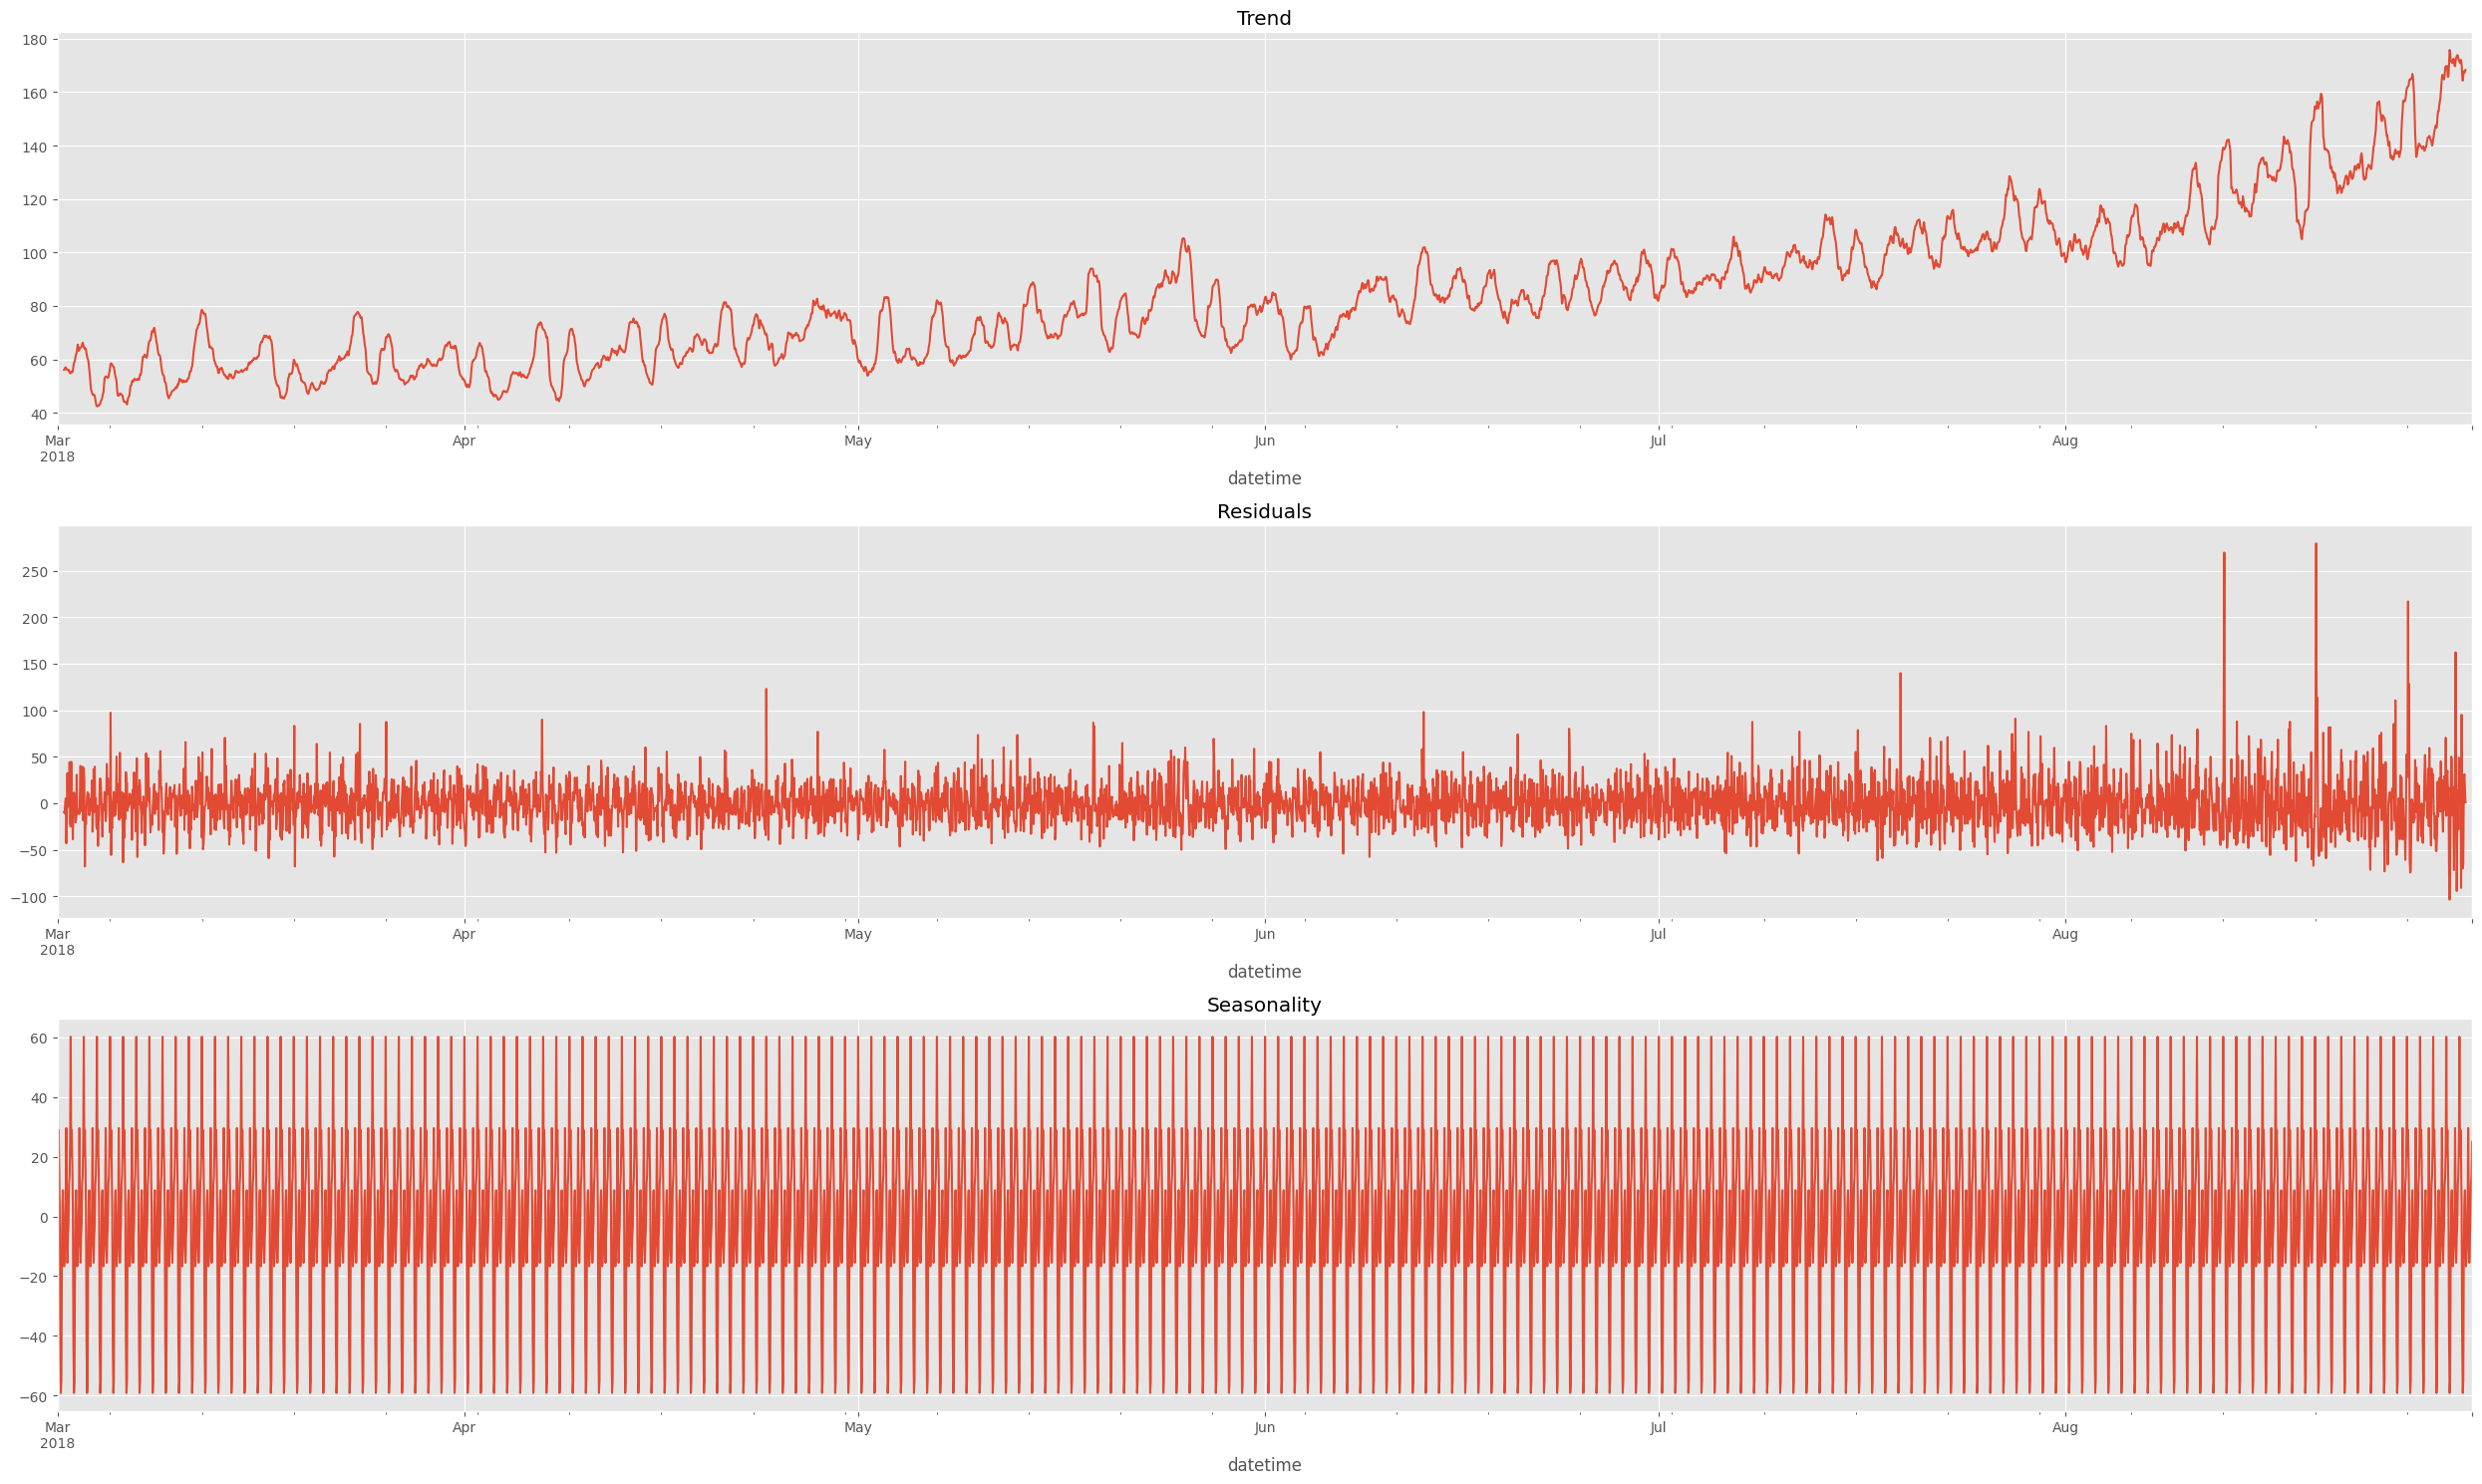

In [15]:
decomposed = seasonal_decompose(df, model='additive')

plt.figure(figsize=(25, 15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(313)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(312)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()
plt.show()

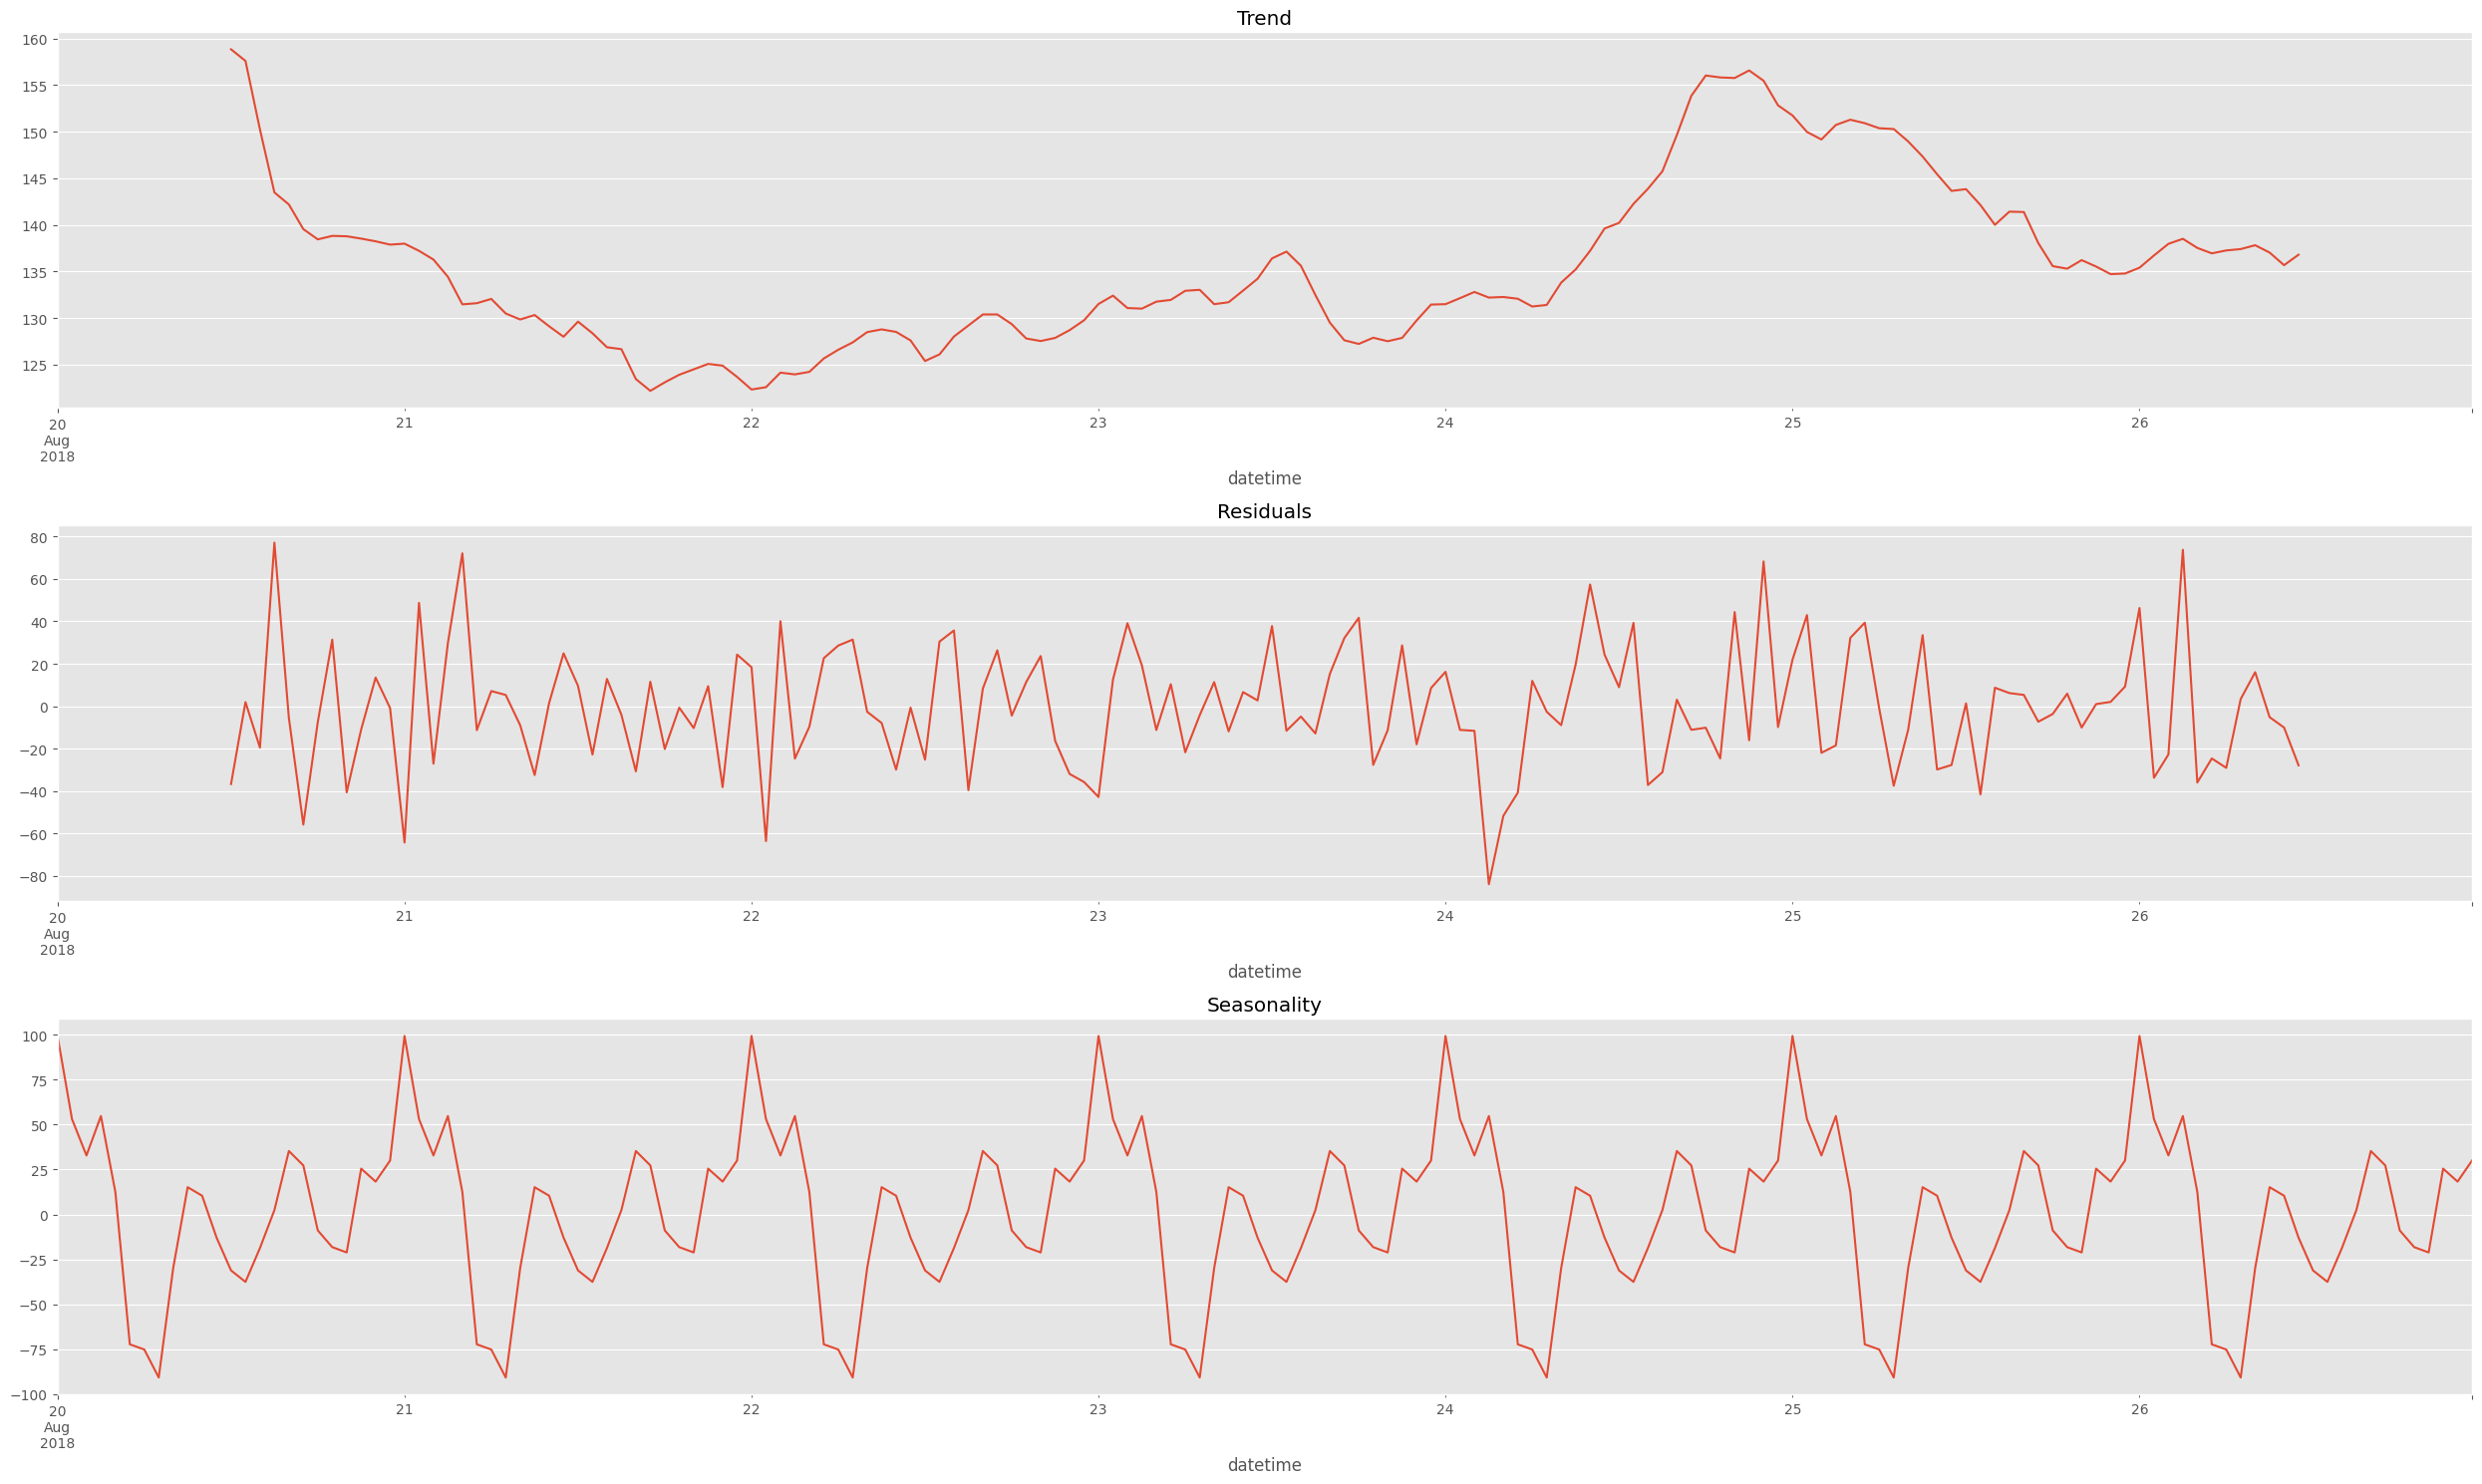

In [16]:
decomposed = seasonal_decompose(last_week, model='additive')

plt.figure(figsize=(25, 15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(313)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(312)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()
plt.show()

<AxesSubplot:ylabel='Frequency'>

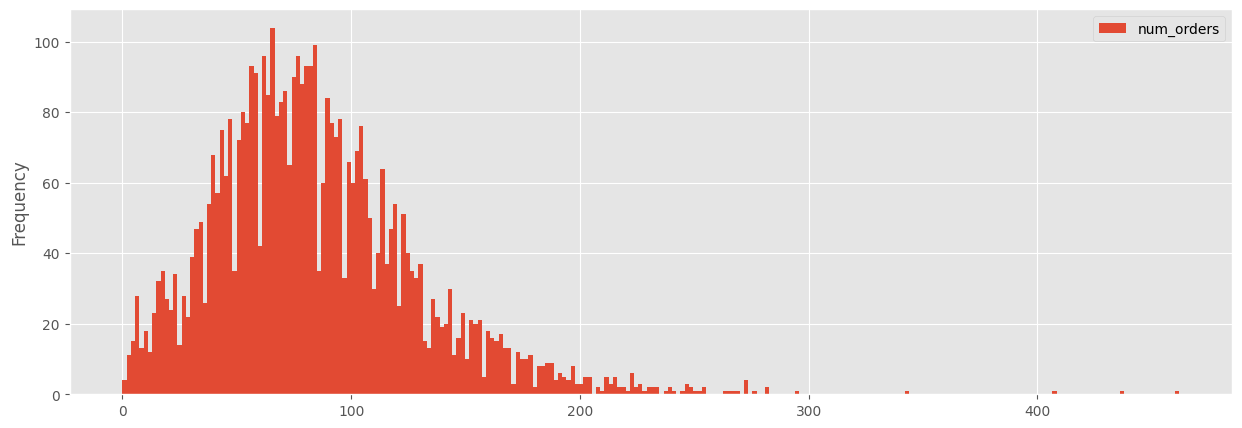

In [17]:
df.plot(kind='hist', bins=250, figsize=(15, 5))

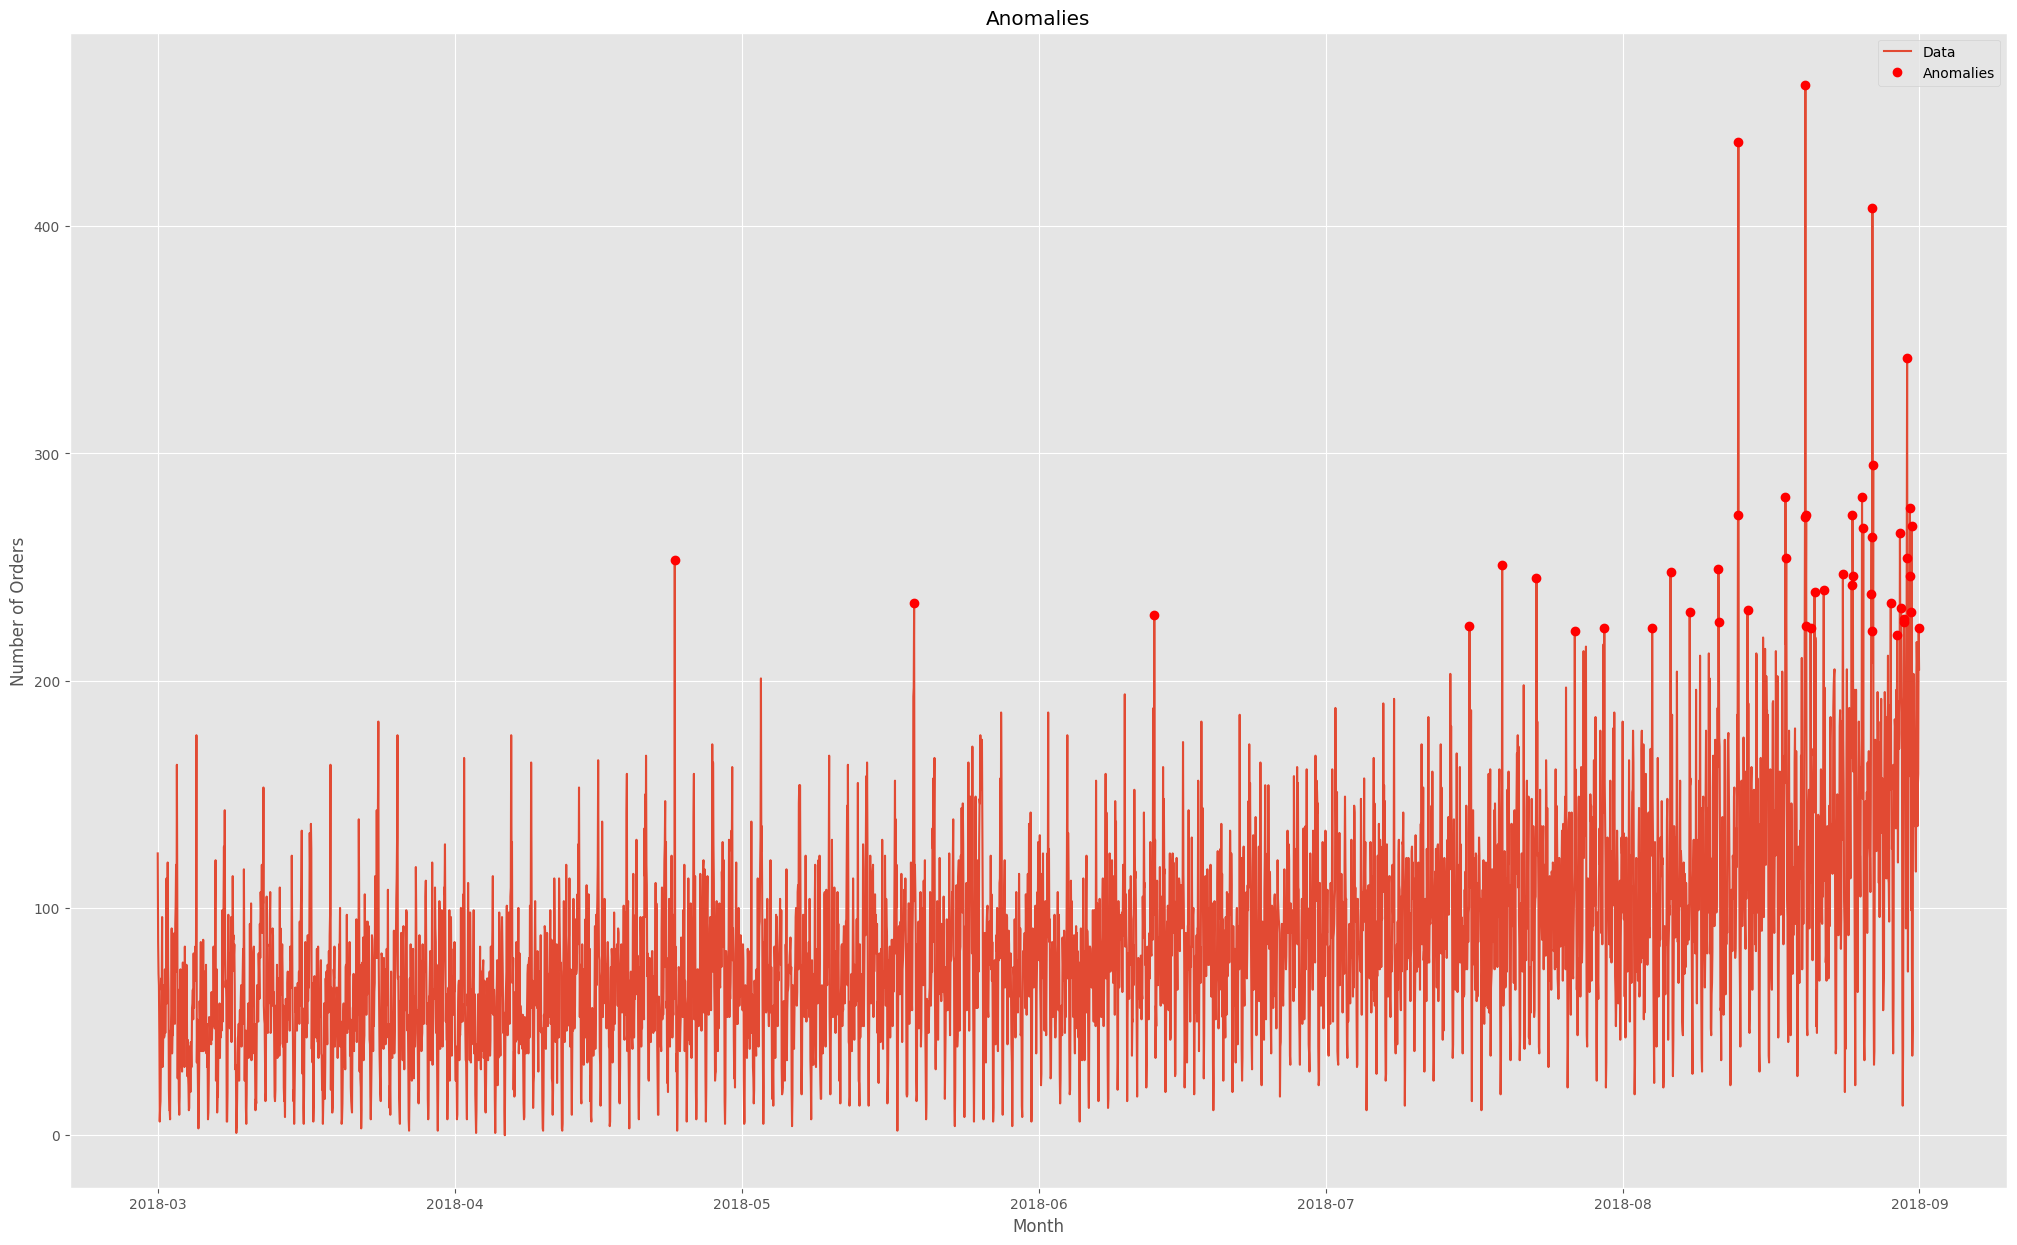

In [18]:
# Finding anomalies
anomalies = df[np.abs(zscore(df)) > 3]

plt.figure(figsize=(25, 15))
plt.plot(df, label='Data')
plt.plot(anomalies.index, anomalies, 'ro', label='Anomalies')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.title('Anomalies')
plt.legend()
plt.show()

In [19]:
anomalies.count()

num_orders    49
dtype: int64

In [20]:
df = df.drop(anomalies.dropna().index)

Conclusions drawn from the graphs are as follows:

1. The increasing trend indicates a growth in the number of taxi orders for this service. Over time, the average number of orders is observed to rise, which suggests an increasing popularity and demand for the service.

2. The time series exhibits non-stationary behavior, where the average varies over time. This implies that the average number of taxi orders is not constant and changes over time.

3. The seasonality graph for the last week reveals that the peak for taxi orders occurs during the nighttime, while the lowest number of orders is observed in the morning. This pattern may indicate customer behavior, where demand for taxis increases in the evenings and nights but decreases in the mornings.

4. The data contains some anomalous values, especially in the last two months (49). We handle these anomalies by excluding them from the data using the 3-sigma rule for anomaly detection.

### Forecasting Preparation

In [21]:
def make_features(df, max_lag, rolling_mean_size):
    data = df.copy()
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

data = make_features(df, 24, 4)
data.head()

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.5


### Train and Test

In [24]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

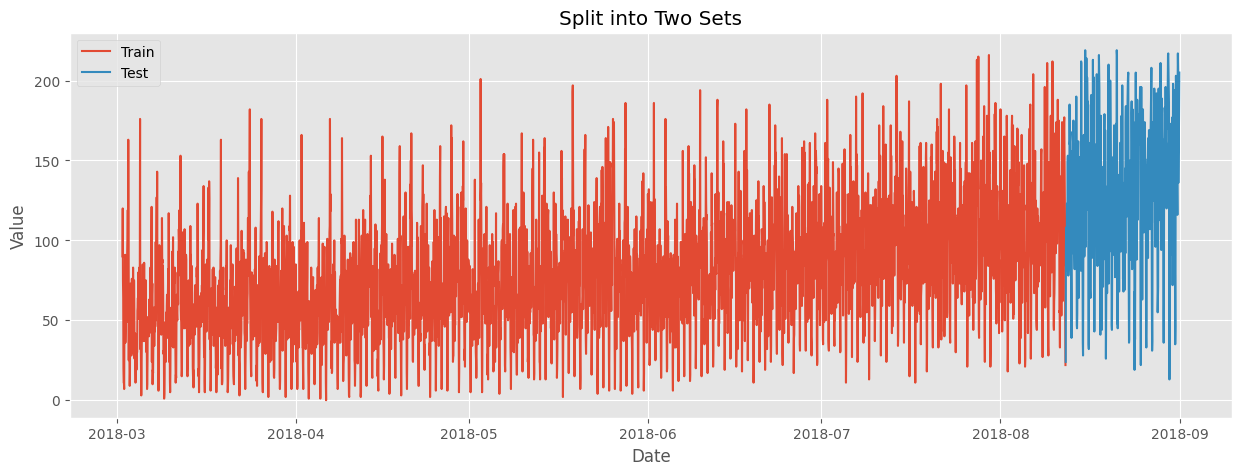

In [25]:
plt.figure(figsize=(15, 5))
plt.plot(train.index, train['num_orders'], label='Train')
plt.plot(test.index, test['num_orders'], label='Test')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Split into Two Sets')
plt.legend()
plt.show()

In [26]:
X_train, y_train = train.drop('num_orders', axis=1), train['num_orders']
X_test, y_test = test.drop('num_orders', axis=1), test['num_orders']

tss = TimeSeriesSplit(n_splits=5)

## Training

In [27]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

cv_scores = cross_val_score(lr_model, X_train, y_train, 
                            scoring=make_scorer(mean_squared_error, 
                                                greater_is_better=False), 
                            cv=tss)
print("Cross-validated RMSE: ", np.sqrt(-cv_scores.mean()))

Cross-validated RMSE:  26.39733971017176


In [28]:
reg = xgb.XGBRegressor()

param_grid = {
    'n_estimators': [5, 10],
    'max_depth': [2, 3]
}
    
grid_search = GridSearchCV(reg, param_grid, 
                           scoring=make_scorer(mean_squared_error, 
                                               greater_is_better=False), 
                           cv=tss)

grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)
print("Best RMSE: ", np.sqrt(-grid_search.best_score_))

Best parameters:  {'max_depth': 3, 'n_estimators': 10}
Best RMSE:  27.04753955689934


In [29]:
df_prophet = pd.DataFrame()
df_prophet['ds'] = train.index 
df_prophet['y'] = train['num_orders'].values

scores = []

for train_index, test_index in tss.split(df_prophet):
    train_data = df_prophet.iloc[train_index]
    test_data = df_prophet.iloc[test_index]

    model = Prophet()
    model.fit(train_data)

    forecast = model.predict(test_data)

    score = np.sqrt(mean_squared_error(test_data['y'], forecast['yhat']))
    scores.append(score)

print("RMSE: ", np.mean(scores))

17:51:58 - cmdstanpy - INFO - Chain [1] start processing
17:51:59 - cmdstanpy - INFO - Chain [1] done processing
17:51:59 - cmdstanpy - INFO - Chain [1] start processing
17:51:59 - cmdstanpy - INFO - Chain [1] done processing
17:51:59 - cmdstanpy - INFO - Chain [1] start processing
17:52:00 - cmdstanpy - INFO - Chain [1] done processing
17:52:00 - cmdstanpy - INFO - Chain [1] start processing
17:52:00 - cmdstanpy - INFO - Chain [1] done processing
17:52:00 - cmdstanpy - INFO - Chain [1] start processing
17:52:00 - cmdstanpy - INFO - Chain [1] done processing


RMSE:  24.505743136283666


## Testing

In [30]:
model = Prophet().fit(df_prophet)

df_prophet_test = pd.DataFrame()
df_prophet_test['ds'] = test.index 
df_prophet_test['y'] = test['num_orders'].values

test_forecast = model.predict(df_prophet_test)

predicted_values = test_forecast['yhat'].values
actual_values = df_prophet_test['y'].values

print("Prophet RMSE for the test set:",  mean_squared_error(actual_values, predicted_values, squared=False))

17:52:53 - cmdstanpy - INFO - Chain [1] start processing
17:52:53 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE for the test set: 35.86629733479648


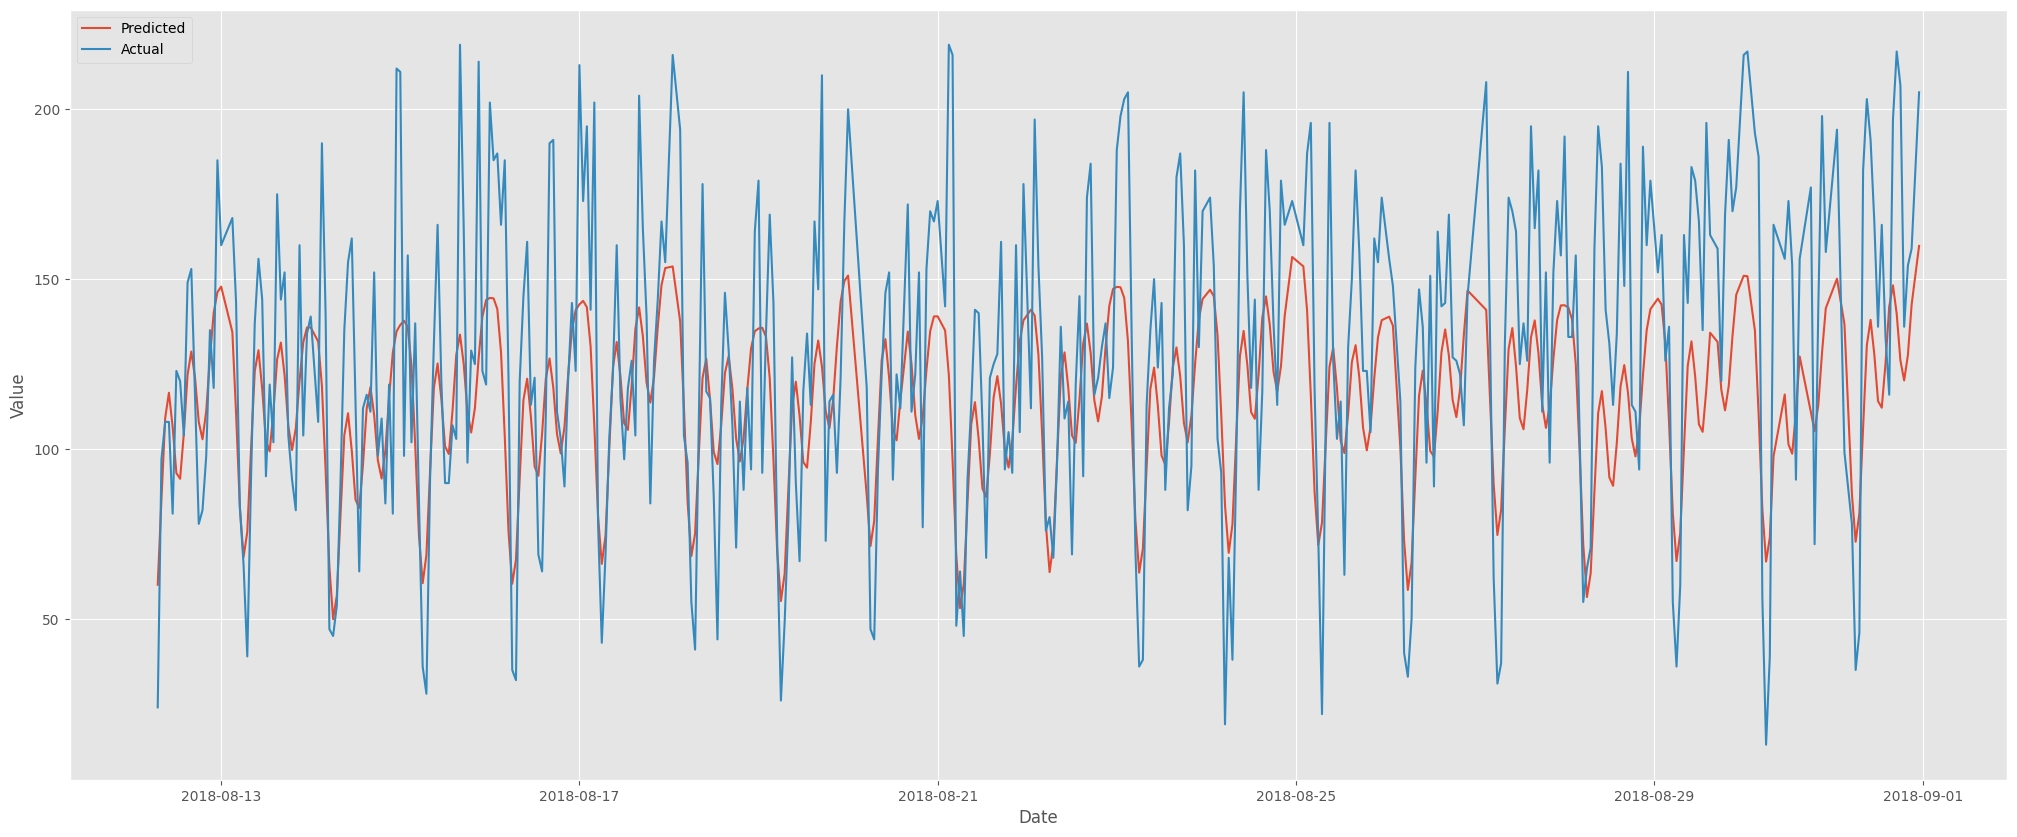

In [31]:
# Visualization of predicted values ​​and actual values
plt.figure(figsize=(25, 10))
plt.plot(df_prophet_test['ds'], predicted_values, label='Predicted')
plt.plot(df_prophet_test['ds'], actual_values, label='Actual')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

## Conclusion

We have evaluated three models - Linear Regression, XGBRegressor, and Prophet, using the RMSE metric for the test set. The Prophet model most accurately predicts the number of taxi orders for the next hour compared to the Linear Regression and XGBRegressor models.

Therefore, for this task of forecasting the number of taxi orders, we recommend using the Prophet model among the three evaluated models, as it demonstrated the best results with the lowest forecasting error.